In [1]:
#for entities extraction
!pip install spacy
!python -m spacy download en_core_web_lg
#for libparserpdf
!pip install pdfminer.six

2024-01-09 10:00:28.591907: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 10:00:28.591978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 10:00:28.594131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 10:00:28.607305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 10:00:30.352934: W tensorflow/compiler/tf2

In [2]:
'''*************************************
#0. Prepare the path for Colab
'''
from google.colab import drive
drive.mount('/content/drive')

import sys
#sys.path.append('/content/drive/MyDrive/Colab Notebooks/7A_data/lib_entitiesExtraction.py')
#sys.path.append('/content/drive/MyDrive/Colab Notebooks/7A_data/lib_parser_pdf.py')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/7A_data/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
'''*************************************
#1. Import relevant libraries and variables

'''
#custom made function
import lib_entitiesExtraction as entitiesExtraction
import lib_parser_pdf as pdf_parser
#import lib_entitiesExtraction
import json
import sqlite3

pdf_path = "/content/drive/MyDrive/Colab Notebooks/7A_data/DUK_2023.pdf"

print('parse PDF')
text_org = pdf_parser.convert_pdf_to_txt(pdf_path)

print('text cleansing')
text = text_org.replace('\r', ' ').replace('\n', ' ').replace('\s',' ')

parse PDF
text cleansing


In [5]:
'''*************************************
#2. NLP

'''
#Named Entity Extraction
print('ner')
#see if we need to convert everthing to lower case words - we keep the original format for this case
lower=False
common_words, sentences, words_list,verbs_list = entitiesExtraction.NER_topics(text,lower)
entities_in_sentences = entitiesExtraction.org_extraction(text)

ents_dict = {}

sentence_cnt = 0

#create this list to export the list of ent and cleanse them
f_ent = open('/content/drive/MyDrive/Colab Notebooks/7A_data/entities.txt','w+')
ent_list=[]

print('looping sentences')
for sentence in entities_in_sentences:
    ents_dict[sentence_cnt] = {}
    for entity in sentence:
        ent_type = entity[1]
        ent_name = entity[0]
        ent_name = ent_name.strip()

        if len(ent_name)==0 or ent_name =='':
            continue

        if lower == True:
            ent_name = ent_name.lower()

        if ent_type in( 'ORG','PERSON','FAC','NORP','GPE','LOC','PRODUCT'):
            #take only upper case (1st pos)
            if ent_name[0].islower():
                continue

            if ent_type not in ents_dict[sentence_cnt]:
                ents_dict[sentence_cnt][ent_type]=[]

            ents_dict[sentence_cnt][ent_type].append(ent_name)

            if ent_name not in ent_list:
                ent_list.append(ent_name)
                f_ent.write(ent_name+'\t'+ent_name+'\n')
            ents_dict[sentence_cnt]['VERB'] = verbs_list[sentence_cnt]
        else:
            ents_dict[sentence_cnt][ent_type] = []

    #handle other type
    for entity in sentence:
        ent_type = entity[1]
        ent_name = entity[0]
        ent_name = ent_name.strip()
        if len(ent_name)==0 or ent_name =='':
            continue
        if ent_type not in('ORG','PERSON','FAC','NORP','GPE','LOC','PRODUCT'):
            ents_dict[sentence_cnt][ent_type].append(ent_name)

    sentence_cnt+=1

f_ent.close()

ner
looping sentences


In [6]:
#Insert the entities into SQL database
print('insert')

f = open('result.json','w+')
json.dump(ents_dict,f)

#db file
db_path = 'parsed_network.db'
db_name = 'network_db'
db_name2 = 'sentence_db'

#sql db
conn = sqlite3.connect(db_path)
c = conn.cursor()

sqlstr = "drop table "+db_name
try:
    output = c.execute(sqlstr)
except Exception:
    print('non exists')

sqlstr = "drop table "+db_name2
try:
    output = c.execute(sqlstr)
except Exception:
    print('non exists')


entity_types = ['ORG','PERSON','FAC','NORP','GPE','LOC','PRODUCT']
relation_units = ['DATE','TIME','PERCENT','MONEY','QUANTITY','ORDINAL','CARDINAL']
#create if required
print('create')
sqlstr = "CREATE TABLE IF NOT EXISTS "+db_name+"(SOURCE TEXT, SENTENCE_NO INTEGER, CON_TYPE TEXT, ENTITY TEXT, RELATION_UNIT TEXT, RELATION_VAL TEXT,VERB_LIST TEXT )"
c.execute(sqlstr)
conn.commit()
sqlstr = "CREATE TABLE IF NOT EXISTS "+db_name2+"(SOURCE TEXT, SENTENCE_NO INTEGER, SENTENCE TEXT )"
c.execute(sqlstr)
conn.commit()

insert
non exists
non exists
create


In [7]:
for key, value in ents_dict.items():
    con_type=''
    entity=''
    relation_unit = ''
    relation_val = ''
    verb_list = ''
    #key = sentence number
    sent_item = [(pdf_path, key, str(value))]
    sqlstr = 'insert into '+db_name2+'(SOURCE, SENTENCE_NO, SENTENCE) VALUES (?,?,?)'
    c.executemany(sqlstr, sent_item)

    for sub_key,sub_value in ents_dict[key].items():
        for entity_type in entity_types:
            try:
                entity = str(ents_dict[key][entity_type])[1:-1]
                con_type = entity_type
                verb_list = str(ents_dict[key]['VERB'])[1:-1]
            except Exception:
                continue
        for relation in relation_units:
            try:
                relation_val = ents_dict[key][relation][0]
                relation_unit = relation
            except Exception:
                continue
    if len(con_type+entity+relation_unit+relation_val+verb_list)>0:
        item = [(pdf_path, key, con_type,entity,relation_unit,relation_val,verb_list)]
        sqlstr = 'insert into '+db_name+'(SOURCE, SENTENCE_NO, CON_TYPE, ENTITY, RELATION_UNIT,RELATION_VAL,VERB_LIST) VALUES (?,?,?,?,?,?,?)'
        c.executemany(sqlstr, item)
    if key % 10 == 0:
        conn.commit()

#closing out and output the results
conn.commit()
c.close()

# New section

In [10]:
'''*************************************
#1. Import relevant libraries and variables

'''
#generate network
import sqlite3
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

#db file
db_path = 'parsed_network.db'
db_name = 'network_db'

#sql db
conn = sqlite3.connect(db_path)
c = conn.cursor()

sql_str = "select source, entity,CON_TYPE from network_db where con_type in ('ORG','PERSON','FAC','NORP','GPE','LOC','PRODUCT') and verb_list <> '[]' group by source,CON_TYPE, entity"
df_org = pd.read_sql_query(sql_str, conn)

network_dict={}
edge_list=[]
curr_source =''
curr_entity = ''
org_list = []
person_list = []


In [11]:
'''*************************************
#2. generate the network with all entities connected to Duke Energy - whose annual report is parsed

'''
target_name = 'Duke Energy'
#loop through the database to generate the network format data
for index, row in df_org.iterrows():
    if curr_entity != row['SOURCE']:
        curr_source = row['SOURCE']
        network_dict[curr_source]=[]
    curr_entity = row['ENTITY']
    if len(curr_entity)==0:
        continue
    curr_entities = curr_entity.split(',')
    if len(curr_entities)>1:
        entity1=curr_entities[0].strip()
        if entity1 == '' or entity1=="'":
            curr_entities=curr_entities[1:]
            entity1 = curr_entities[0]
        network_dict[entity1]=[]
        org_list.append(entity1)
        #all entity has relationship with target company
        entry = (target_name,entity1,{'weight':1})
        edge_list.append(entry)
        for entity in curr_entities[1:]:
            entity2=entity.strip()
            if entity2=='' or entity2 =="'":
                continue
            network_dict[entity1].append(entity2)
            entry = (entity1,entity2,{'weight':1})
            edge_list.append(entry)
            org_list.append(entity2)

            entry = (target_name,entity2,{'weight':1})
            edge_list.append(entry)

networkx
prep data for neo4j


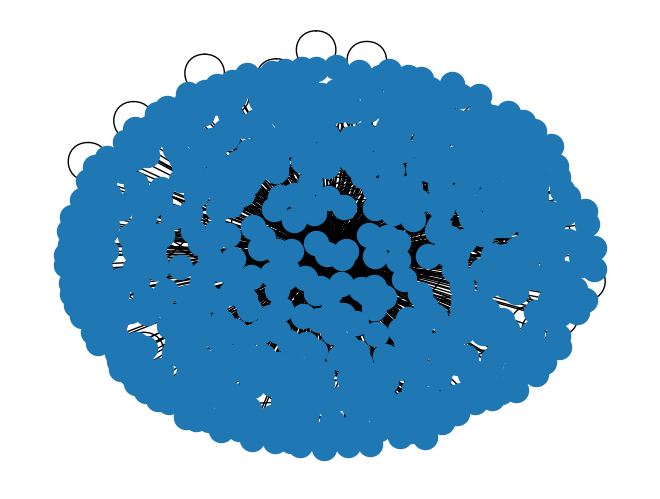

In [13]:
#Generate the output in networkX
print('networkx')

#output the network
G = nx.from_edgelist(edge_list)
pos = nx.spring_layout(G)
nx.draw(G)
plt.savefig('network.png')

#Generate output for Neo4J
print('prep data for neo4j')
f_org_node=open('node.csv','w+')
f_org_node.write('nodename\n')

f_person_node=open('node_person.csv','w+')
f_person_node.write('nodename\n')

f_vertex=open('edge.csv','w+')
f_vertex.write('nodename1,nodename2,weight\n')

unique_org = set(org_list)
for entity in unique_org:
    f_org_node.write(entity+'\n')
f_org_node.close()

unique_person = set(person_list)
for entity in unique_person:
    f_person_node.write(entity+'\n')
f_person_node.close()

for edge in edge_list:
    node1, node2, weight_dict = edge
    weight = weight_dict['weight']
    f_vertex.write(node1+','+node2+','+str(weight)+'\n')
f_vertex.close()

'''
What to do afterwards:
step1: Copy the file to the import directory:

sudo cp '/home/jeff/AI_Finance_book/7B_IndustryNetwork/edge.csv' /var/lib/neo4j/import/edge.csv
sudo cp '/home/jeff/AI_Finance_book/7B_IndustryNetwork/node.csv' /var/lib/neo4j/import/node.csv

step2: start the neo4j server
sudo service neo4j restart

check if the server is runnning
journalctl -e -u neo4j

step3: use the browser to go to the neo4j server
http://localhost:7474/browser/
https://neo4j.com/developer/guide-importing-data-and-etl/#_exporting_the_data_to_csv

step4: run the following scripts at neo4j browser
MATCH (n) DETACH DELETE n;

USING PERIODIC COMMIT
LOAD CSV WITH HEADERS FROM "file:///node.csv" AS row
CREATE (:ENTITY {node: row.nodename});

CREATE INDEX ON :ENTITY(node);


USING PERIODIC COMMIT
LOAD CSV WITH HEADERS FROM "file:///edge.csv" AS row
MATCH (vertex1:ENTITY {node: row.nodename1})
MATCH (vertex2:ENTITY {node: row.nodename2})
MERGE (vertex1)-[:LINK]->(vertex2);

MATCH (n:ENTITY)-[:LINK]->(ENTITY) RETURN n;

'''